In [22]:
import numpy as np
import matplotlib.pyplot as plt

# pre-written helper modules

In [23]:
# those are pre-written helper modules, included in hands-on labs from DeepLearning.AI
# They're made to focus your attention on learning the concepts, not spending time on boilerplate setup.

from lab_utils_multi import  load_house_data, run_gradient_descent 
from lab_utils_multi import  norm_plot, plt_equal_scale, plot_cost_i_w
from lab_utils_common import dlc

# Apply consistent plotting style (custom DeepLearning.AI theme)
plt.style.use('./deeplearning.mplstyle')

# Loading the dataset 

In [24]:
# load the dataset
X_train, y_train = load_house_data()

# Display shapes of features and target
print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)

# Assign feature names for easier reference when plotting
X_features = ['size(sqft)','bedrooms','floors','age']

X_train shape: (99, 4)
y_train shape: (99,)


In [25]:
# print to check first feature values

print("First feature (size):", X_train[:, 0])
print("Shape of first feature:", X_train[:, 0].shape)
print("Target shape:", y_train.shape)

First feature (size): [1244. 1947. 1725. 1959. 1314.  864. 1836. 1026. 3194.  788. 1200. 1557.
 1430. 1220. 1092.  848. 1682. 1768. 1040. 1652. 1088. 1316. 1593.  972.
 1097. 1004.  904. 1694. 1073. 1419. 1164. 1935. 1216. 2482. 1200. 1840.
 1851. 1660. 1096. 1775. 2030. 1784. 1073. 1552. 1953. 1224. 1616.  816.
 1349. 1571. 1486. 1506. 1097. 1764. 1208. 1470. 1768. 1654. 1029. 1120.
 1150.  816. 1040. 1392. 1603. 1215. 1073. 2599. 1431. 2090. 1790. 1484.
 1040. 1431. 1159. 1547. 1983. 1056. 1180. 1358.  960. 1456. 1446. 1208.
 1553.  882. 2030. 1040. 1616.  803. 1430. 1656. 1541.  948. 1224. 1432.
 1660. 1212. 1050.]
Shape of first feature: (99,)
Target shape: (99,)


# Plotting each feature vs. the target (price)

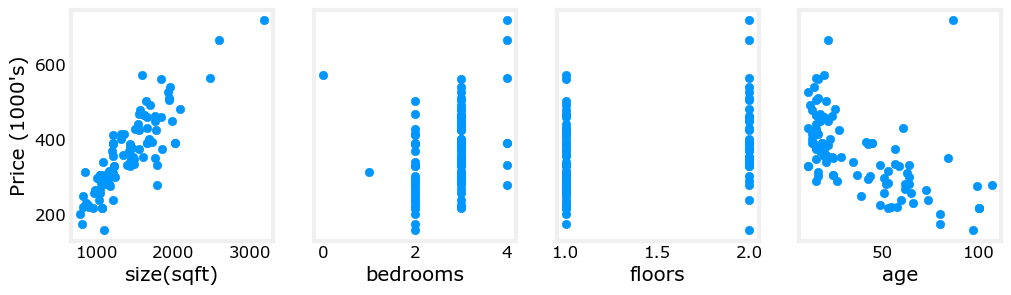

In [26]:
_,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)

for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

# it's similar to : 

# # feature 1 : 
# plt.scatter(X_train[:,0], y_train, marker='x', c='b')
# plt.title("Housing Prices")
# plt.ylabel('Price (in 1000s of dollars)')
# plt.xlabel(X_features[0])
# plt.show()

# These are equivalent to the multi-subplot version above

## mean 

\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j 
\end{align}



In [27]:
def mean(x):
    """
    Compute the mean of each feature column in the dataset x.
    
    Parameters:
    x (ndarray): A 2D numpy array of shape (n_samples, n_features)
    
    Returns:
    ndarray: A 1D array containing the mean of each feature
    """
    n_samples = x.shape[0]
    n_features = x.shape[1]
    mean = np.zeros(n_features, dtype=float)
    
    for j in range(n_features):
        s = 0.0
        for i in range(n_samples):
            s += x[i][j]
        mean[j] = s / n_samples
    
    return mean


In [28]:
# Custom mean function
mean_v = mean(X_train)

# Numpy built-in mean for verification
mu = np.mean(X_train, axis=0)

print("Custom mean: ", mean_v)
print("Numpy mean:  ", mu)


Custom mean:  [1.41837374e+03 2.71717172e+00 1.38383838e+00 3.83838384e+01]
Numpy mean:   [1.41837374e+03 2.71717172e+00 1.38383838e+00 3.83838384e+01]


## Standard deviation (σ)	

\begin{align}
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2 
\end{align}
$$

\sigma_j = \sqrt{ \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2 }
$$

In [29]:
def standard_deviation(x, mean):
    """
    Compute the standard deviation of each feature column in x.

    Parameters:
    x (ndarray): A 2D numpy array of shape (n_samples, n_features)
    mean (ndarray): Mean values of each feature (same shape as x.shape[1])

    Returns:
    ndarray: A 1D array containing the standard deviation of each feature
    """
    n_samples = x.shape[0]
    n_features = x.shape[1]
    std_dev = np.zeros(n_features, dtype=float)

    for j in range(n_features):
        sum_sq_diff = 0.0
        for i in range(n_samples):
            sum_sq_diff += (x[i][j] - mean[j]) ** 2
        std_dev[j] = np.sqrt(sum_sq_diff / n_samples)
    
    return std_dev


In [30]:
# Custom standard deviation
std_v = standard_deviation(X_train, mean_v)

# NumPy built-in for verification
sigma = np.std(X_train, axis=0)

print("Custom std: ", std_v)
print("NumPy std:  ", sigma)


Custom std:  [411.61562893   0.65196523   0.48631932  25.77788069]
NumPy std:   [411.61562893   0.65196523   0.48631932  25.77788069]



### z-score normalization 

$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{4}$$ 

>**Implementation Note:** When normalizing the features, it is important
to store the values used for normalization - the mean value and the standard deviation used for the computations. After learning the parameters
from the model, we often want to predict the prices of houses we have not
seen before. Given a new x value (living room area and number of bed-
rooms), we must first normalize x using the mean and standard deviation
that we had previously computed from the training set.



In [31]:
def z_score_normalization(x, mean, std):
    """
    Perform z-score normalization on dataset x using provided mean and std.

    Parameters:
    x (ndarray): 2D numpy array of shape (n_samples, n_features)
    mean (ndarray): 1D array of mean values for each feature
    std (ndarray): 1D array of standard deviation values for each feature

    Returns:
    ndarray: Normalized dataset where each feature has zero mean and unit variance
    """
    n_samples = x.shape[0]
    n_features = x.shape[1]

    # Create a copy to avoid modifying the original data in-place
    x_norm = np.copy(x)

    for j in range(n_features):
        for i in range(n_samples):
            x_norm[i][j] = (x[i][j] - mean[j]) / std[j]
    
    return x_norm

In [32]:
norm_x =z_score_normalization(X_train,mean_v,std_v)
print(norm_x)

[[-4.23632450e-01  4.33808841e-01 -7.89272336e-01  9.93726440e-01]
 [ 1.28427160e+00  4.33808841e-01  1.26698980e+00 -8.29542143e-01]
 [ 7.44933479e-01  4.33808841e-01  1.26698980e+00  1.40281572e-01]
 [ 1.31342501e+00  4.33808841e-01  1.26698980e+00 -9.07128040e-01]
 [-2.53570880e-01 -1.10001528e+00 -7.89272336e-01 -9.45920989e-01]
 [-1.34682383e+00 -1.10001528e+00 -7.89272336e-01  1.07131234e+00]
 [ 1.01460254e+00  4.33808841e-01 -7.89272336e-01 -8.29542143e-01]
 [-9.53252767e-01  4.33808841e-01 -7.89272336e-01  1.79074520e-01]
 [ 4.31379699e+00  1.96763296e+00  1.26698980e+00  1.88596426e+00]
 [-1.53146210e+00 -1.10001528e+00 -7.89272336e-01  1.61441362e+00]
 [-5.30528294e-01 -1.10001528e+00  1.26698980e+00 -8.29542143e-01]
 [ 3.36785712e-01 -1.10001528e+00 -7.89272336e-01 -7.90749194e-01]
 [ 2.82454353e-02  4.33808841e-01 -7.89272336e-01 -7.13163297e-01]
 [-4.81939274e-01 -1.10001528e+00 -7.89272336e-01 -9.07128040e-01]
 [-7.92909002e-01 -1.10001528e+00 -7.89272336e-01  9.93726440e

## Visualizing the effect of normalization on features


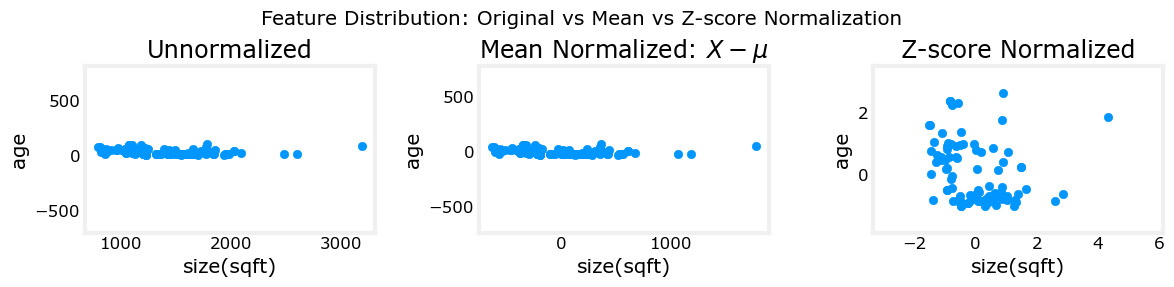

In [ ]:
# Comparing original data, mean-centered data, and z-score normalized data
# Plotting the relationship between "age" (X[:,0]) and "size (sqft)" (X[:,3])

import matplotlib.pyplot as plt

# Compute mean-normalized data (X - μ)
X_mean = X_train - mean_v

# Create subplots: one row, three columns
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

# Original (unnormalized) data
ax[0].scatter(X_train[:, 0], X_train[:, 3])
ax[0].set_xlabel(X_features[0])
ax[0].set_ylabel(X_features[3])
ax[0].set_title("Unnormalized")
ax[0].axis('equal')

# Mean normalization (X - μ)
ax[1].scatter(X_mean[:, 0], X_mean[:, 3])
ax[1].set_xlabel(X_features[0])
ax[1].set_ylabel(X_features[3])  # Fixed copy-paste error from ax[0]
ax[1].set_title(r"Mean Normalized: $X - \mu$")
ax[1].axis('equal')

# Z-score normalization: (X - μ) / σ
ax[2].scatter(norm_x[:, 0], norm_x[:, 3])
ax[2].set_xlabel(X_features[0])
ax[2].set_ylabel(X_features[3])  # Fixed same here
ax[2].set_title("Z-score Normalized")
ax[2].axis('equal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Feature Distribution: Original vs Mean vs Z-score Normalization")

plt.show()
